In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sun Apr 13 09:06:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install ultralytics

In [ ]:
 from ultralytics import YOLO

In [ ]:
!pip install roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="0YOIxlpYtePWBqfaq4gu")
project = rf.workspace("deneme-tfvg6").project("tumorneuro")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to tumorneuro-1 in yolov11:: 100%|██████████| 36724/36724 [00:06<00:00, 5691.48it/s]


### **Dataset Visualization**

In [ ]:
# Verify Dataset Structure
import os
os.listdir("tumorneuro-1")  # Should show train, valid, test, and data.yaml

['train',
 'README.roboflow.txt',
 'data.yaml',
 'test',
 'README.dataset.txt',
 'valid']

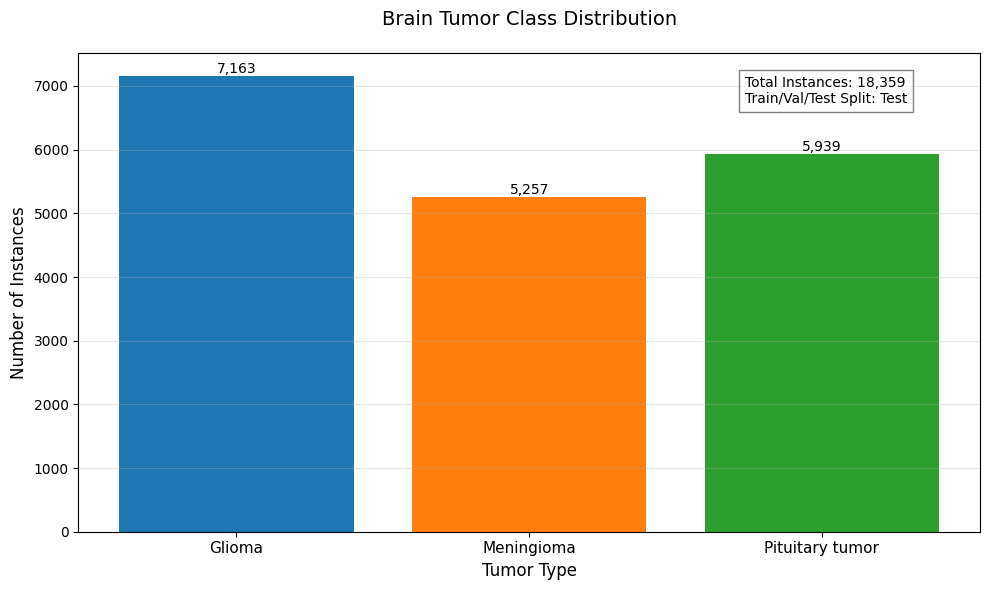

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Class names from your data.yaml
class_names = ['Glioma', 'Meningioma', 'Pituitary tumor']

# Initialize counter
class_counts = defaultdict(int)

# Directory where dataset was downloaded
dataset_base = "tumorneuro-1"

# Process all splits (train, valid, test)
for split in ['train', 'valid', 'test']:
    label_dir = os.path.join(dataset_base, split, 'labels')

    # Verify labels directory exists
    if not os.path.exists(label_dir):
        print(f"Warning: {label_dir} not found, skipping")
        continue

    # Count annotations in all label files
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    class_counts[class_id] += 1

# Convert to class names and sort
sorted_classes = sorted(class_counts.items())
class_labels = [class_names[cls_id] for cls_id, _ in sorted_classes]
count_values = [count for _, count in sorted_classes]

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, count_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom')

plt.title('Brain Tumor Class Distribution', fontsize=14, pad=20)
plt.xlabel('Tumor Type', fontsize=12)
plt.ylabel('Number of Instances', fontsize=12)
plt.xticks(fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add dataset info box
textstr = '\n'.join((
    f'Total Instances: {sum(count_values):,}',
    f'Train/Val/Test Split: {split.capitalize()}'))
plt.gcf().text(0.75, 0.82, textstr, fontsize=10,
               bbox=dict(facecolor='white', alpha=0.5))


plt.tight_layout()
plt.show()

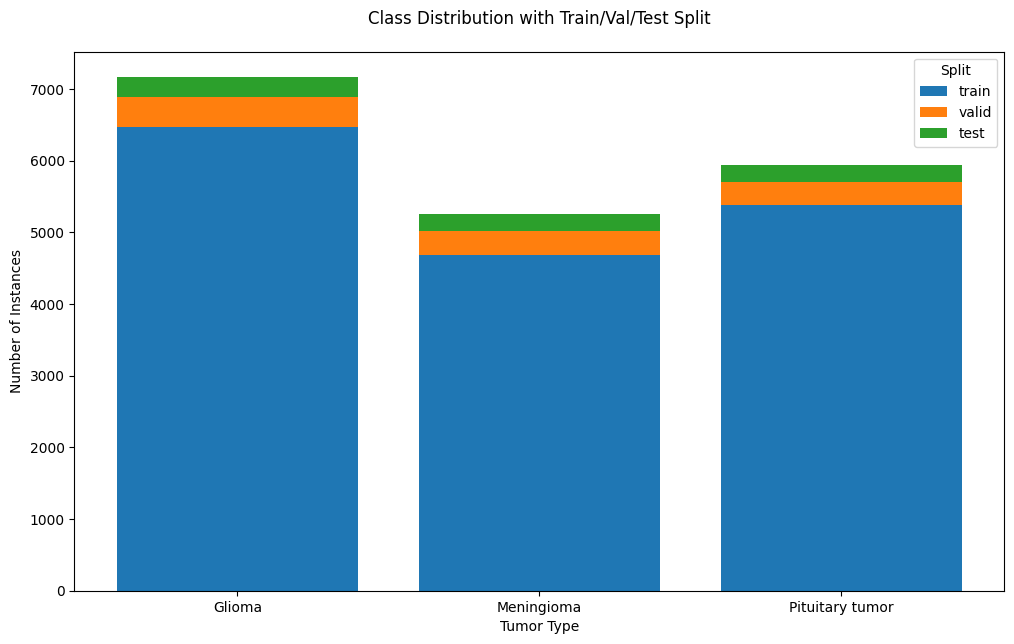

In [ ]:
# Initialize nested counter
split_counts = {split: defaultdict(int) for split in ['train', 'valid', 'test']}

for split in ['train', 'valid', 'test']:
    label_dir = os.path.join(dataset_base, split, 'labels')

    if not os.path.exists(label_dir):
        continue

    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    split_counts[split][class_id] += 1

# Plot stacked bars
fig, ax = plt.subplots(figsize=(12, 7))
split_colors = {'train': '#1f77b4', 'valid': '#ff7f0e', 'test': '#2ca02c'}

for i, class_name in enumerate(class_names):
    bottom = 0
    for split in ['train', 'valid', 'test']:
        count = split_counts[split][i]
        ax.bar(class_name, count, bottom=bottom,
               color=split_colors[split], label=split if i == 0 else "")
        bottom += count

ax.set_title('Class Distribution with Train/Val/Test Split', pad=20)
ax.set_xlabel('Tumor Type')
ax.set_ylabel('Number of Instances')
ax.legend(title='Split')
plt.show()

### **Model Training**

In [ ]:
# Load a model
model = YOLO("yolo11n-seg.pt")

# Train the model
train_results = model.train(
    data="/content/tumorneuro-1/data.yaml",  # path to dataset YAML
    epochs=10,  # number of training epochs
    imgsz=640,  # training image size
    batch=16,
    device=0,  # to run on gpu
)

100%|██████████| 5.90M/5.90M [00:00<00:00, 92.4MB/s]


Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/content/tumorneuro-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line

100%|██████████| 755k/755k [00:00<00:00, 22.4MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 81.8MB/s]


AMP: checks passed ✅


train: Scanning /content/tumorneuro-1/train/labels... 16523 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16523/16523 [00:07<00:00, 2116.53it/s]


train: New cache created: /content/tumorneuro-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/tumorneuro-1/valid/labels... 1091 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1091/1091 [00:01<00:00, 844.39it/s]

val: New cache created: /content/tumorneuro-1/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.8G      1.361      2.329      2.505      1.326         11        640: 100%|██████████| 1033/1033 [05:57<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:13<00:00,  2.58it/s]

                   all       1091       1091      0.659      0.616      0.652      0.408      0.655      0.613      0.645      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.43G      1.353      2.214       1.31      1.314         11        640: 100%|██████████| 1033/1033 [05:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:13<00:00,  2.65it/s]

                   all       1091       1091      0.552      0.602       0.61      0.381      0.553      0.609      0.619      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.44G      1.304      2.126      1.144      1.286         11        640: 100%|██████████| 1033/1033 [05:38<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:12<00:00,  2.70it/s]

                   all       1091       1091      0.727      0.723      0.744      0.481      0.722      0.737      0.748      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.46G      1.249      2.028      1.009      1.252         11        640: 100%|██████████| 1033/1033 [05:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:13<00:00,  2.66it/s]

                   all       1091       1091      0.804      0.782      0.827      0.543      0.797      0.776      0.824      0.535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.47G      1.203      1.943     0.9155       1.22         11        640: 100%|██████████| 1033/1033 [05:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:13<00:00,  2.67it/s]

                   all       1091       1091      0.832      0.798      0.851      0.569      0.827      0.801      0.848      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.49G      1.153      1.868     0.8299       1.19         11        640: 100%|██████████| 1033/1033 [05:37<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:13<00:00,  2.67it/s]

                   all       1091       1091      0.817      0.796      0.851      0.584      0.809      0.805      0.854      0.566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10       3.5G      1.116      1.804     0.7645      1.169         11        640: 100%|██████████| 1033/1033 [05:37<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:12<00:00,  2.74it/s]

                   all       1091       1091      0.864      0.807      0.871      0.602       0.87      0.813       0.88      0.589



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.52G      1.073      1.732     0.6968      1.139         11        640: 100%|██████████| 1033/1033 [05:36<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:12<00:00,  2.74it/s]


                   all       1091       1091      0.863      0.824      0.888      0.625      0.868       0.83      0.891      0.608

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.54G      1.023      1.658       0.63      1.109         11        640: 100%|██████████| 1033/1033 [05:37<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:12<00:00,  2.76it/s]


                   all       1091       1091      0.868      0.866      0.899      0.638      0.872       0.87      0.903      0.622

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.55G     0.9843      1.602     0.5799      1.088         11        640: 100%|██████████| 1033/1033 [05:36<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:12<00:00,  2.81it/s]


                   all       1091       1091      0.881      0.858      0.907      0.643       0.88      0.856      0.904      0.625

10 epochs completed in 0.982 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.0MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,835,153 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/35 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   6%|▌         | 2/35 [00:01<00:26,  1.24it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:16<00:00,  2.13it/s]


                   all       1091       1091      0.882      0.858      0.907      0.643      0.881      0.855      0.905      0.625
                Glioma        429        429      0.851      0.823      0.882      0.566      0.847      0.816      0.877      0.525
            Meningioma        329        329      0.924      0.958      0.973      0.778      0.924      0.957      0.973      0.773
       Pituitary tumor        333        333       0.87      0.793      0.865      0.585      0.871      0.791      0.864      0.578
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train


## **Model Evaluation**

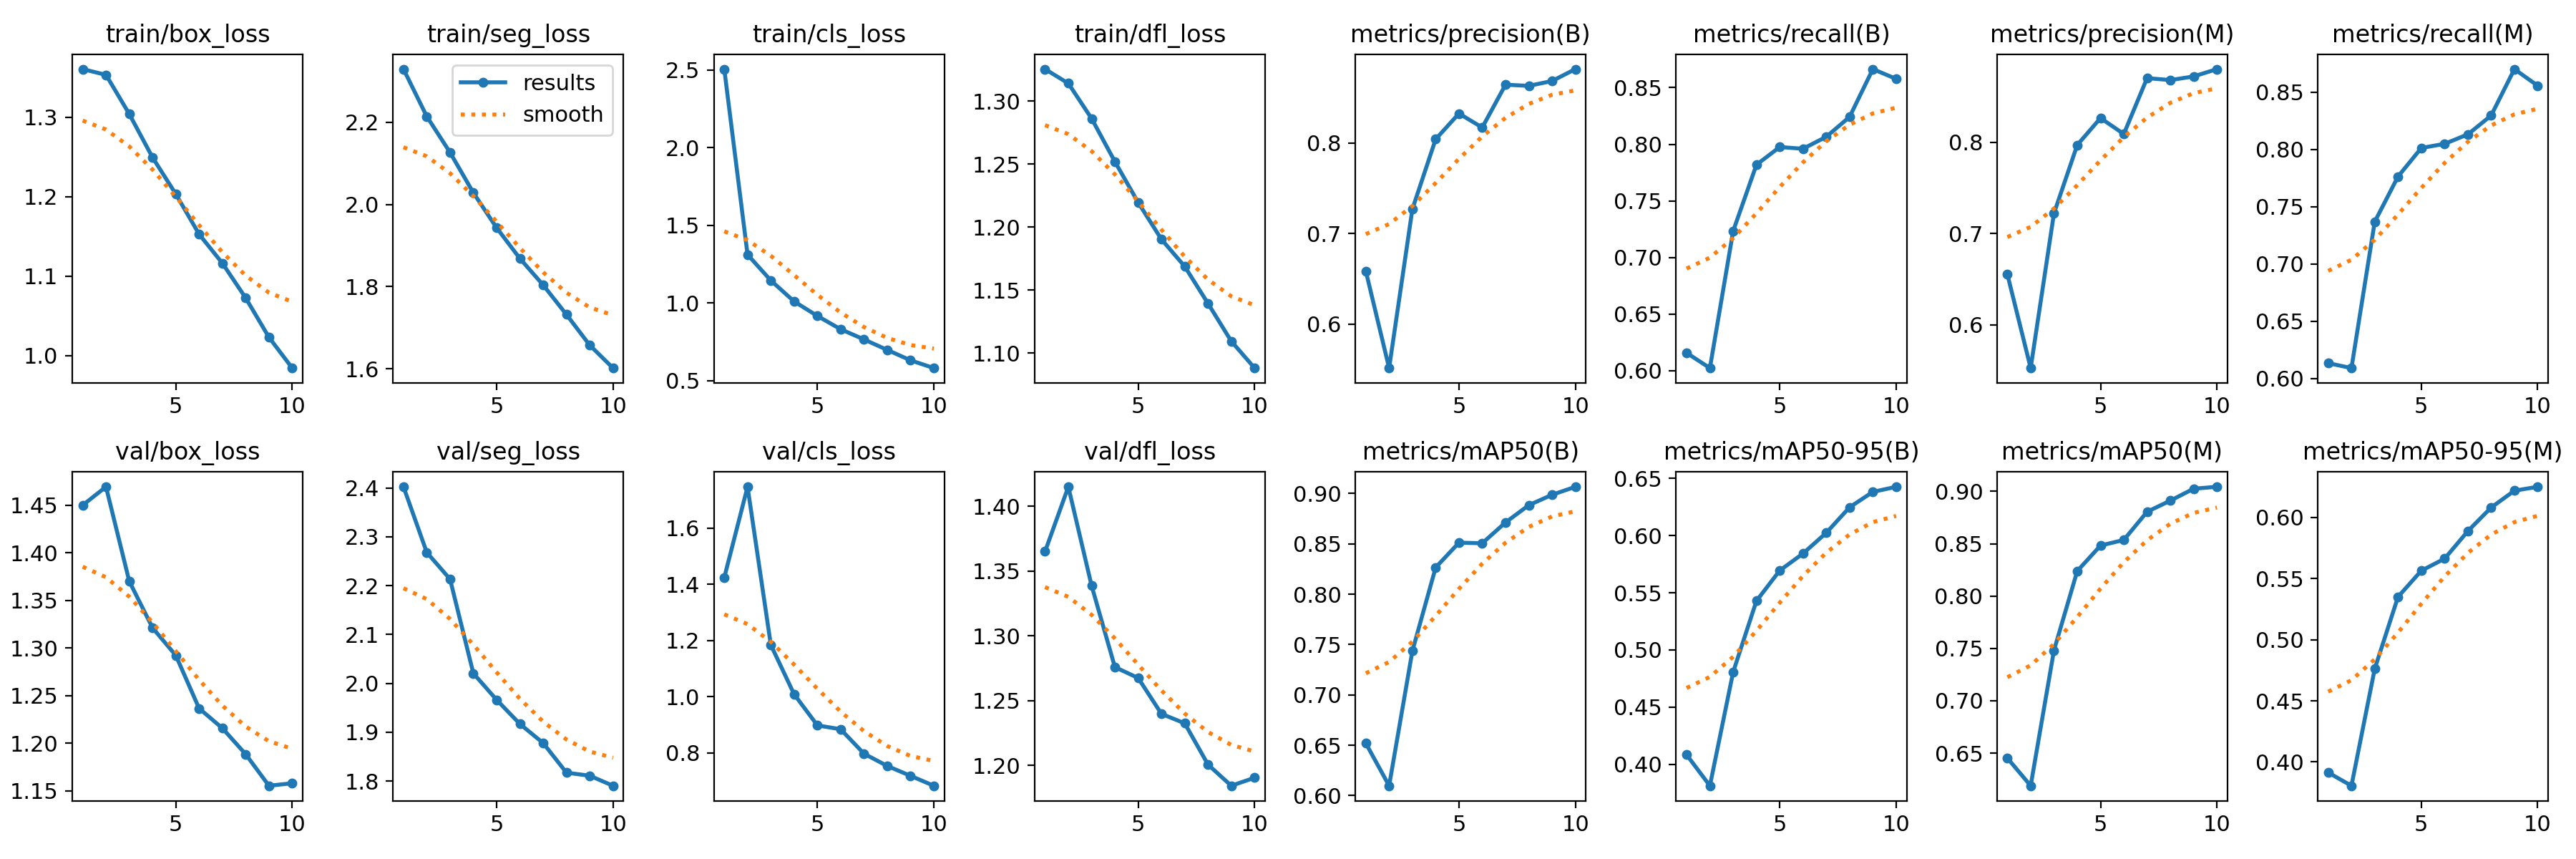

In [ ]:
from IPython.display import display, Image
Image('/content/runs/segment/train/results.png', height=400, width=1000)

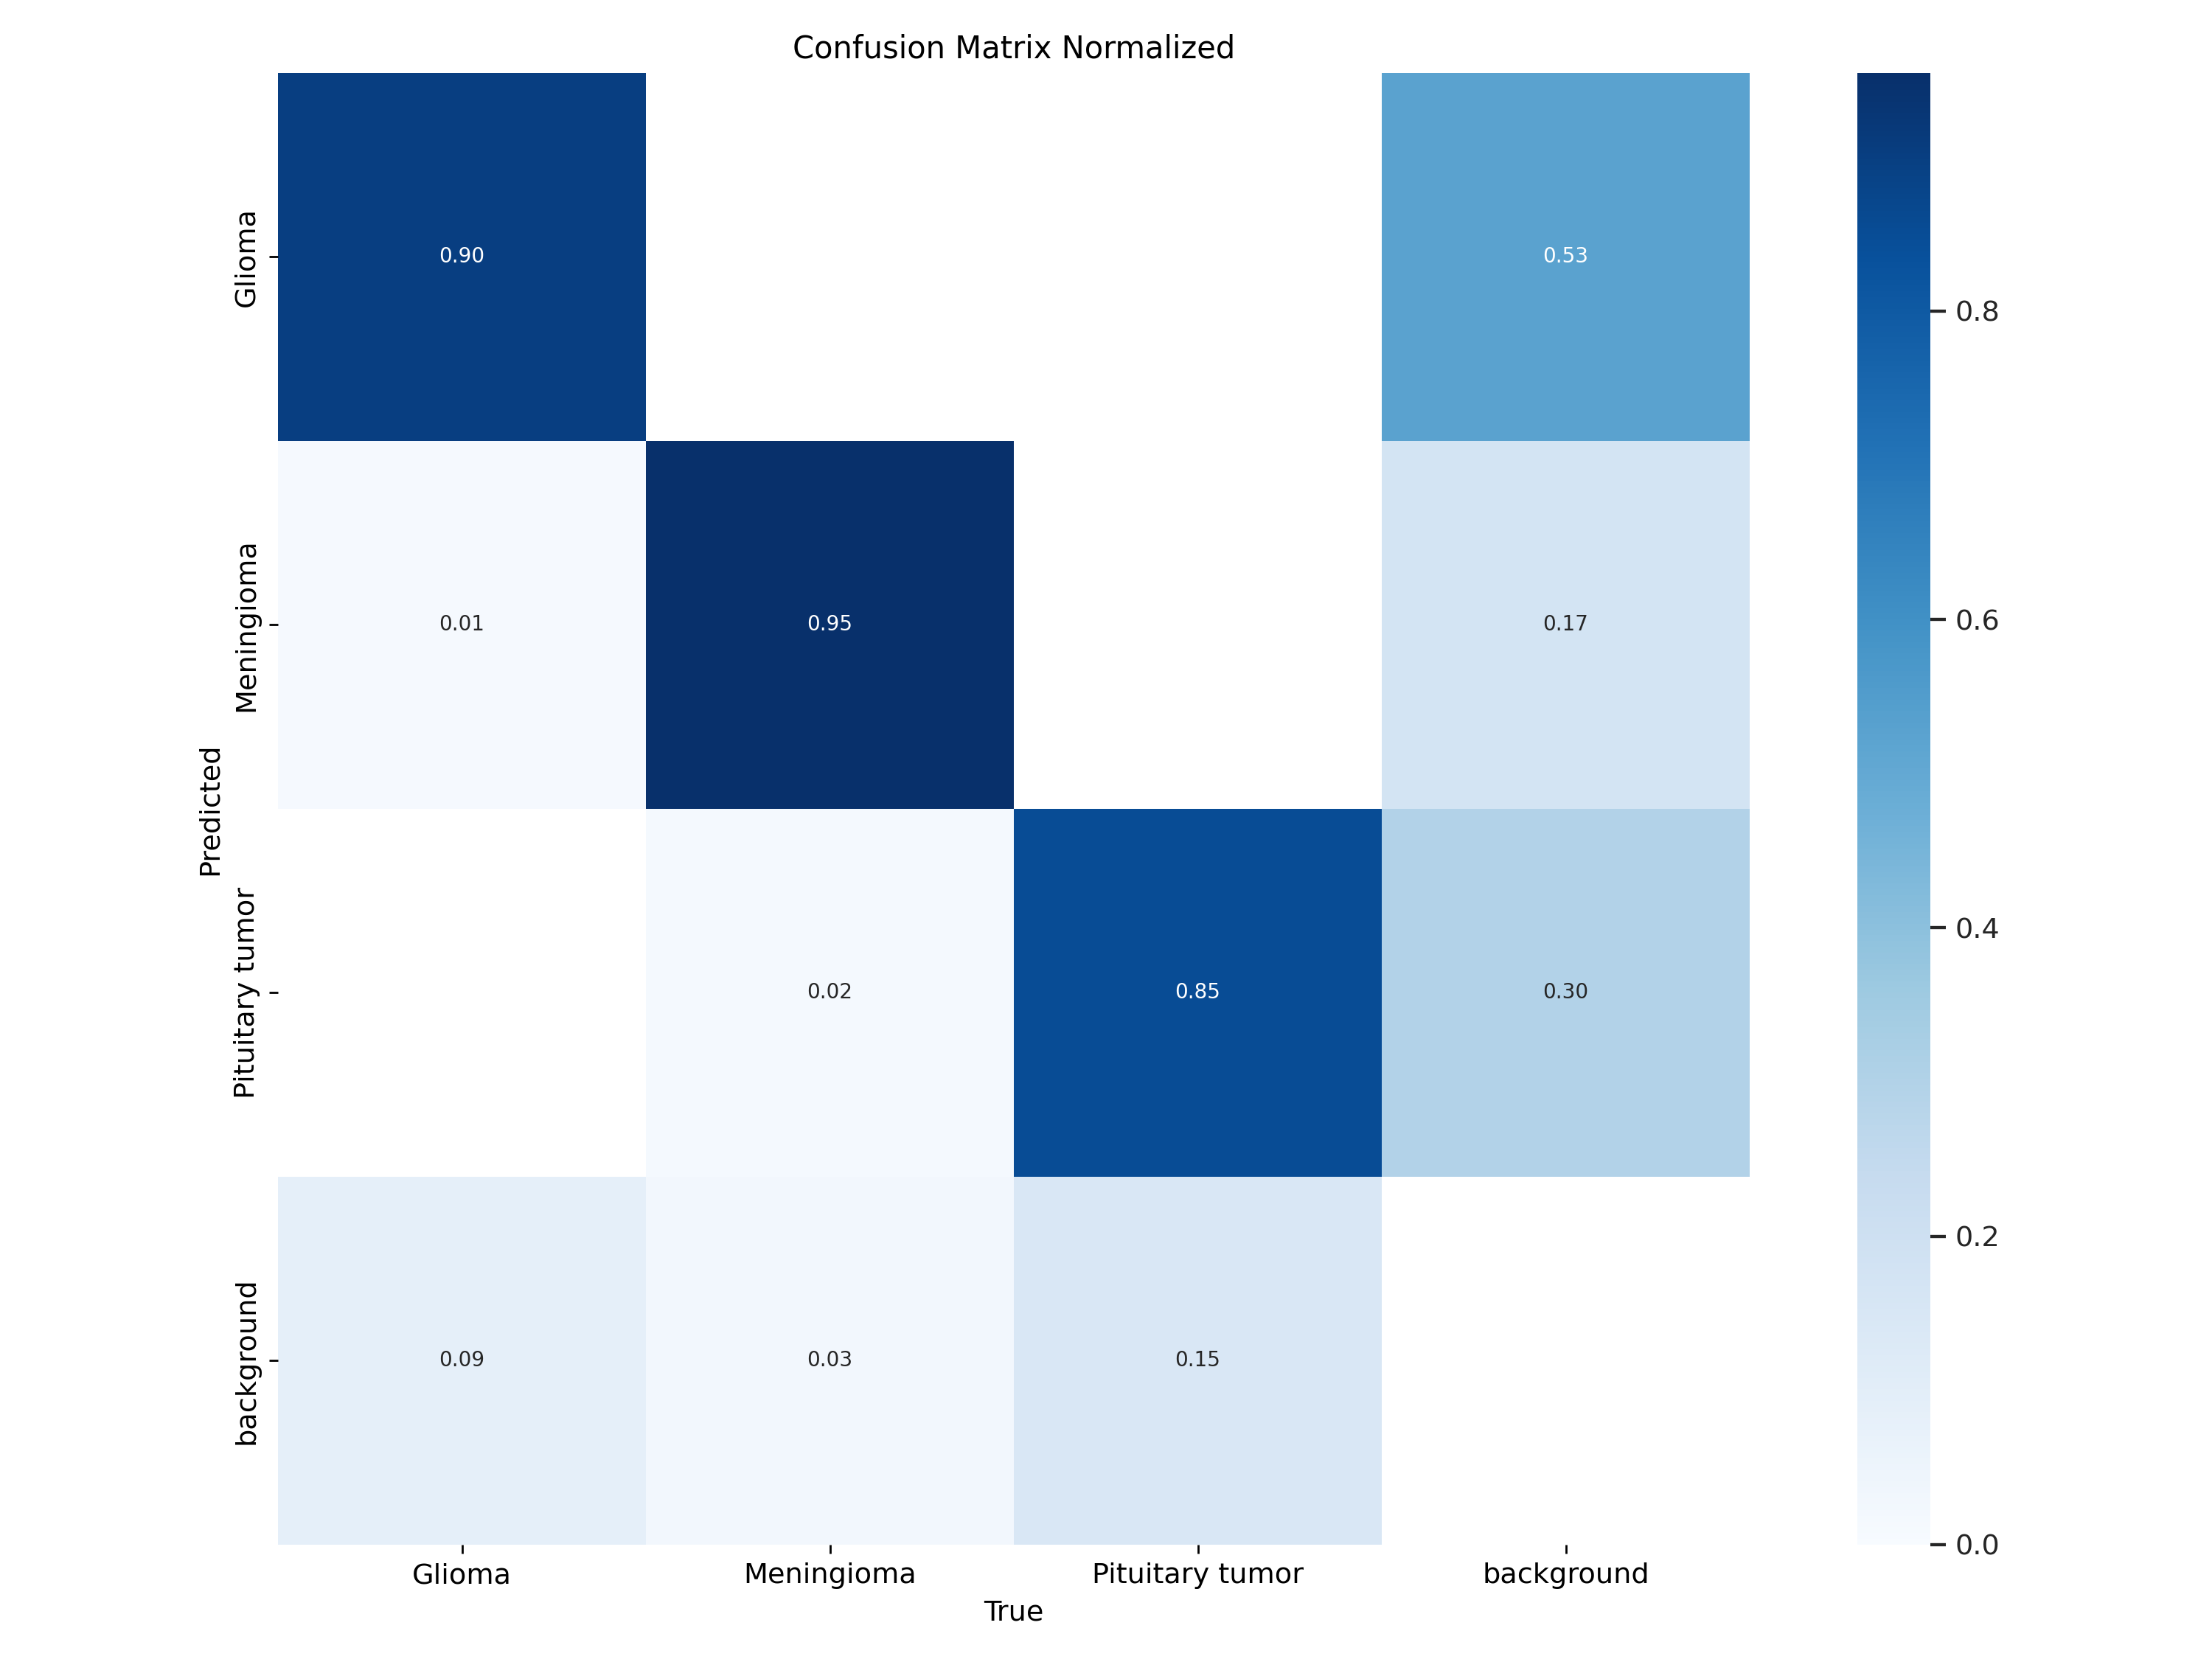

In [ ]:
Image('/content/runs/segment/train/confusion_matrix_normalized.png', width=600)

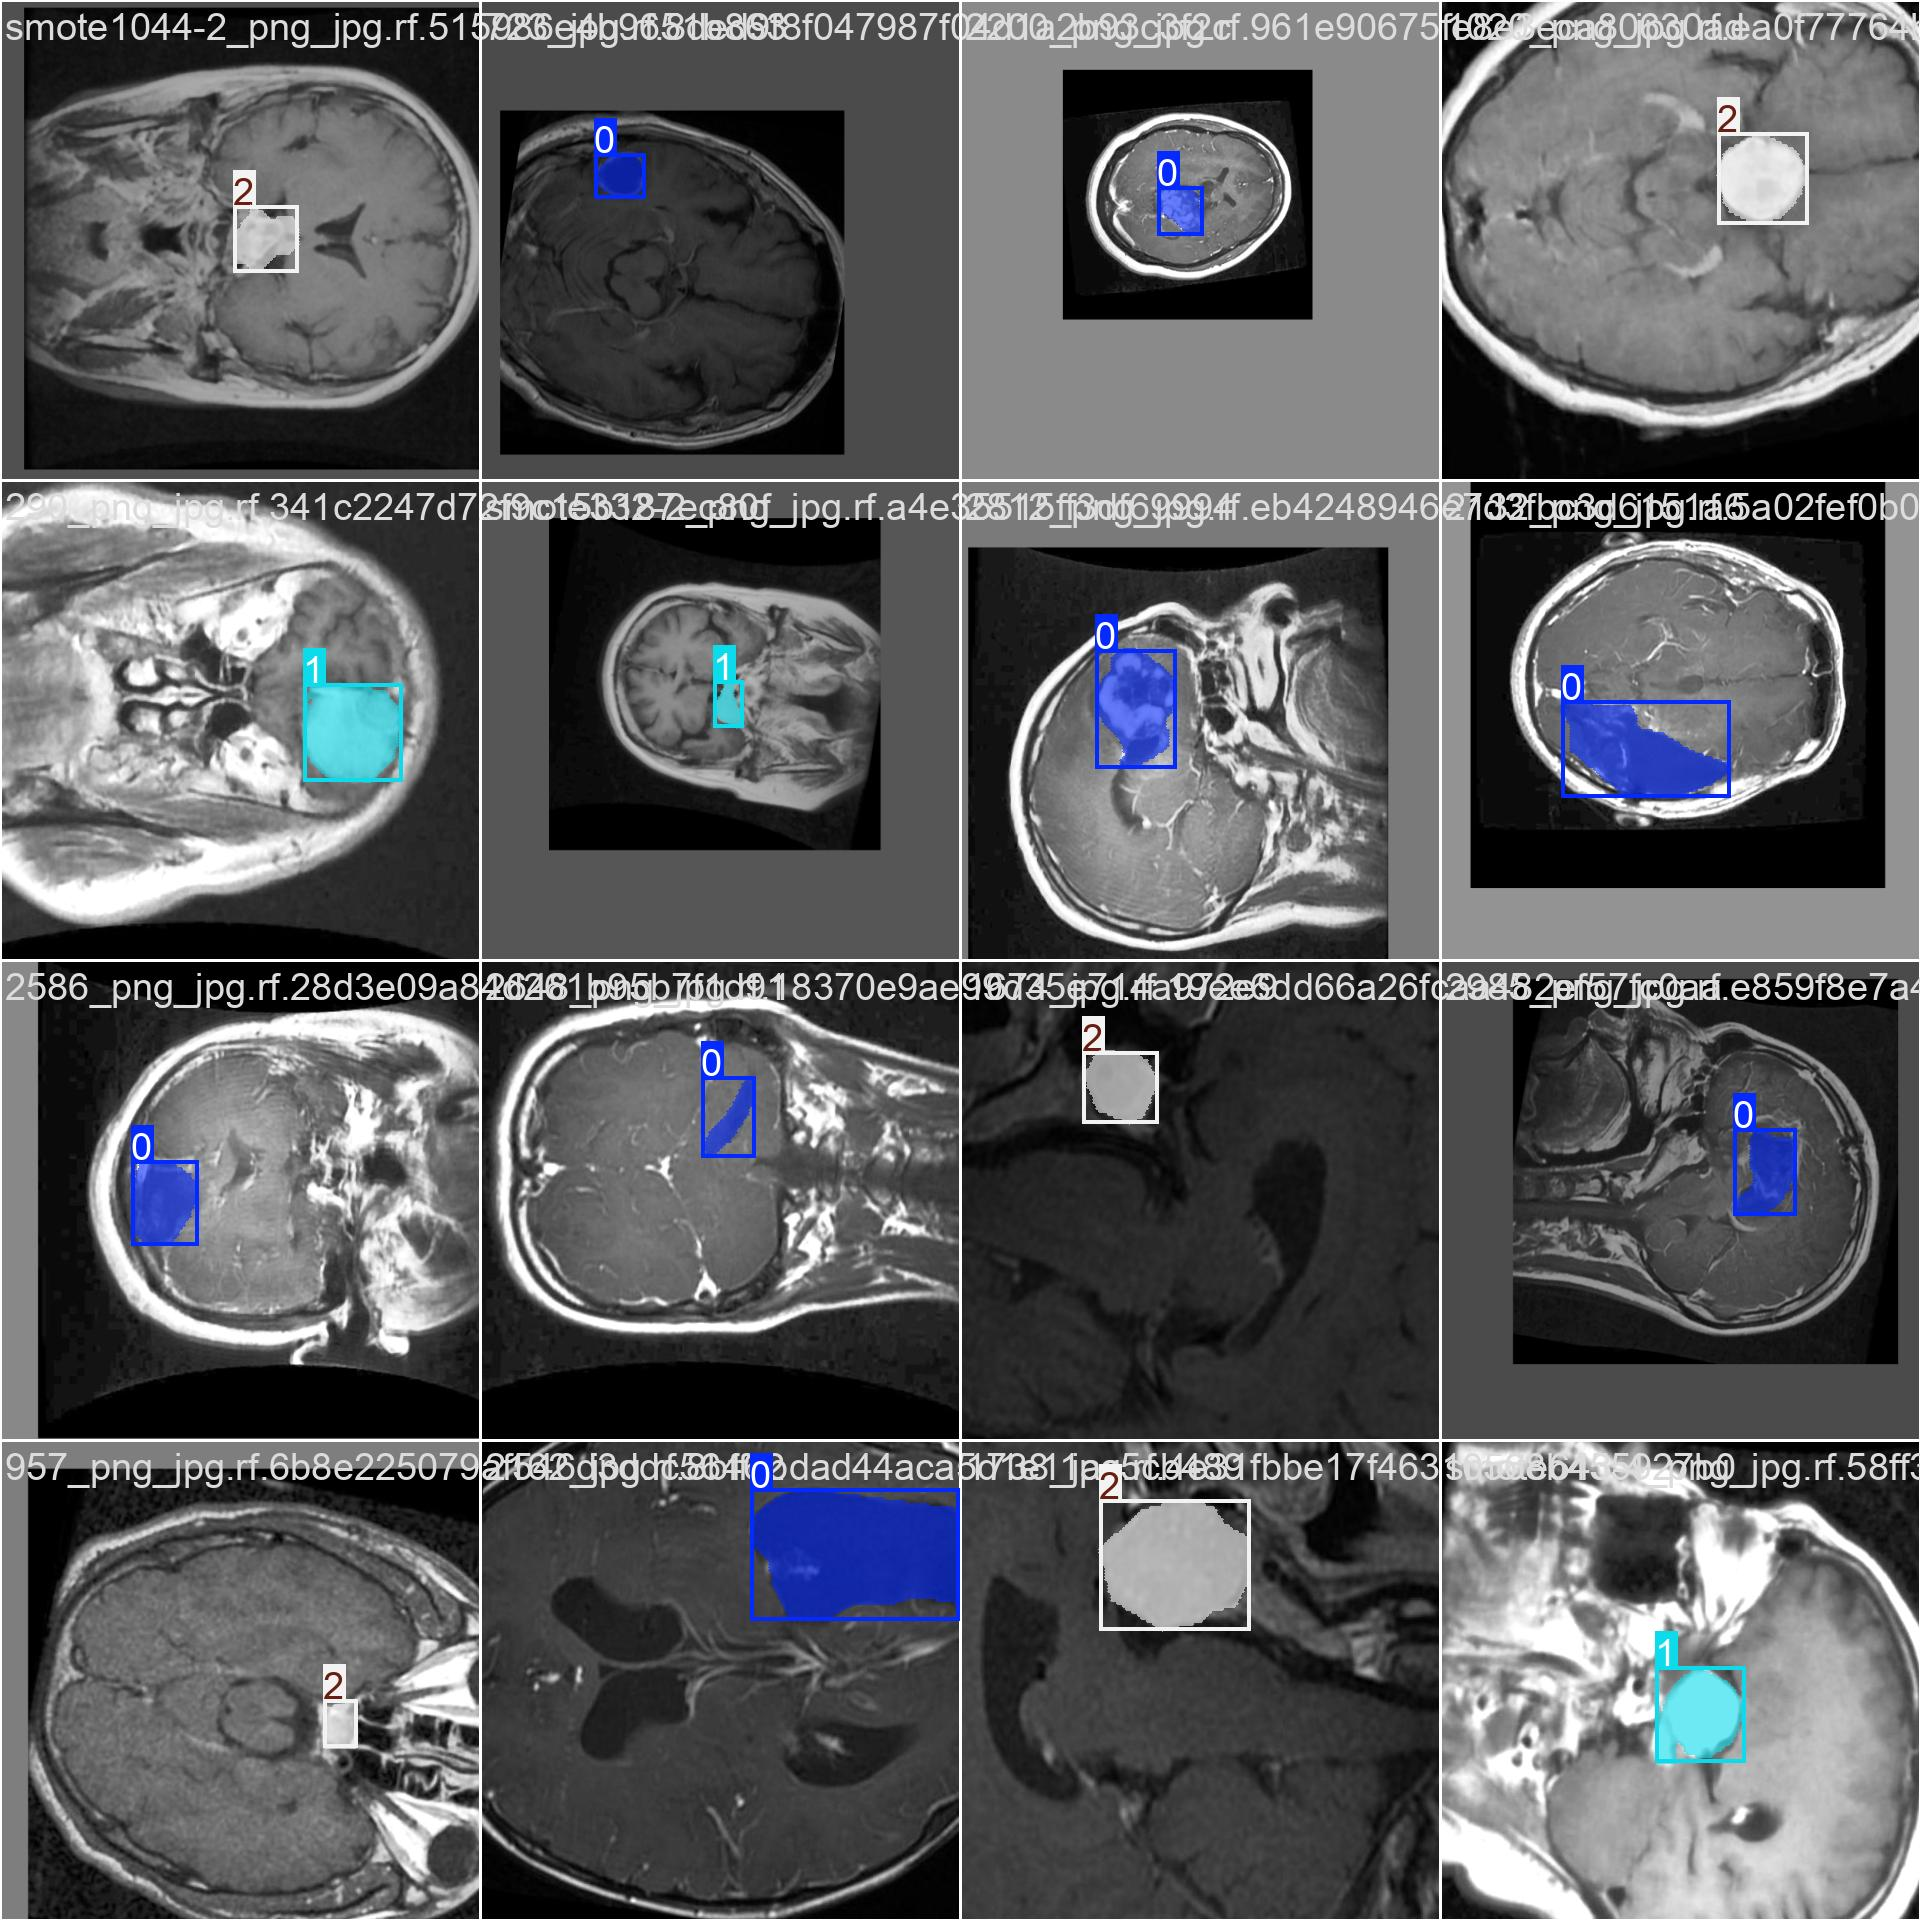

In [ ]:
Image('/content/runs/segment/train/train_batch0.jpg')

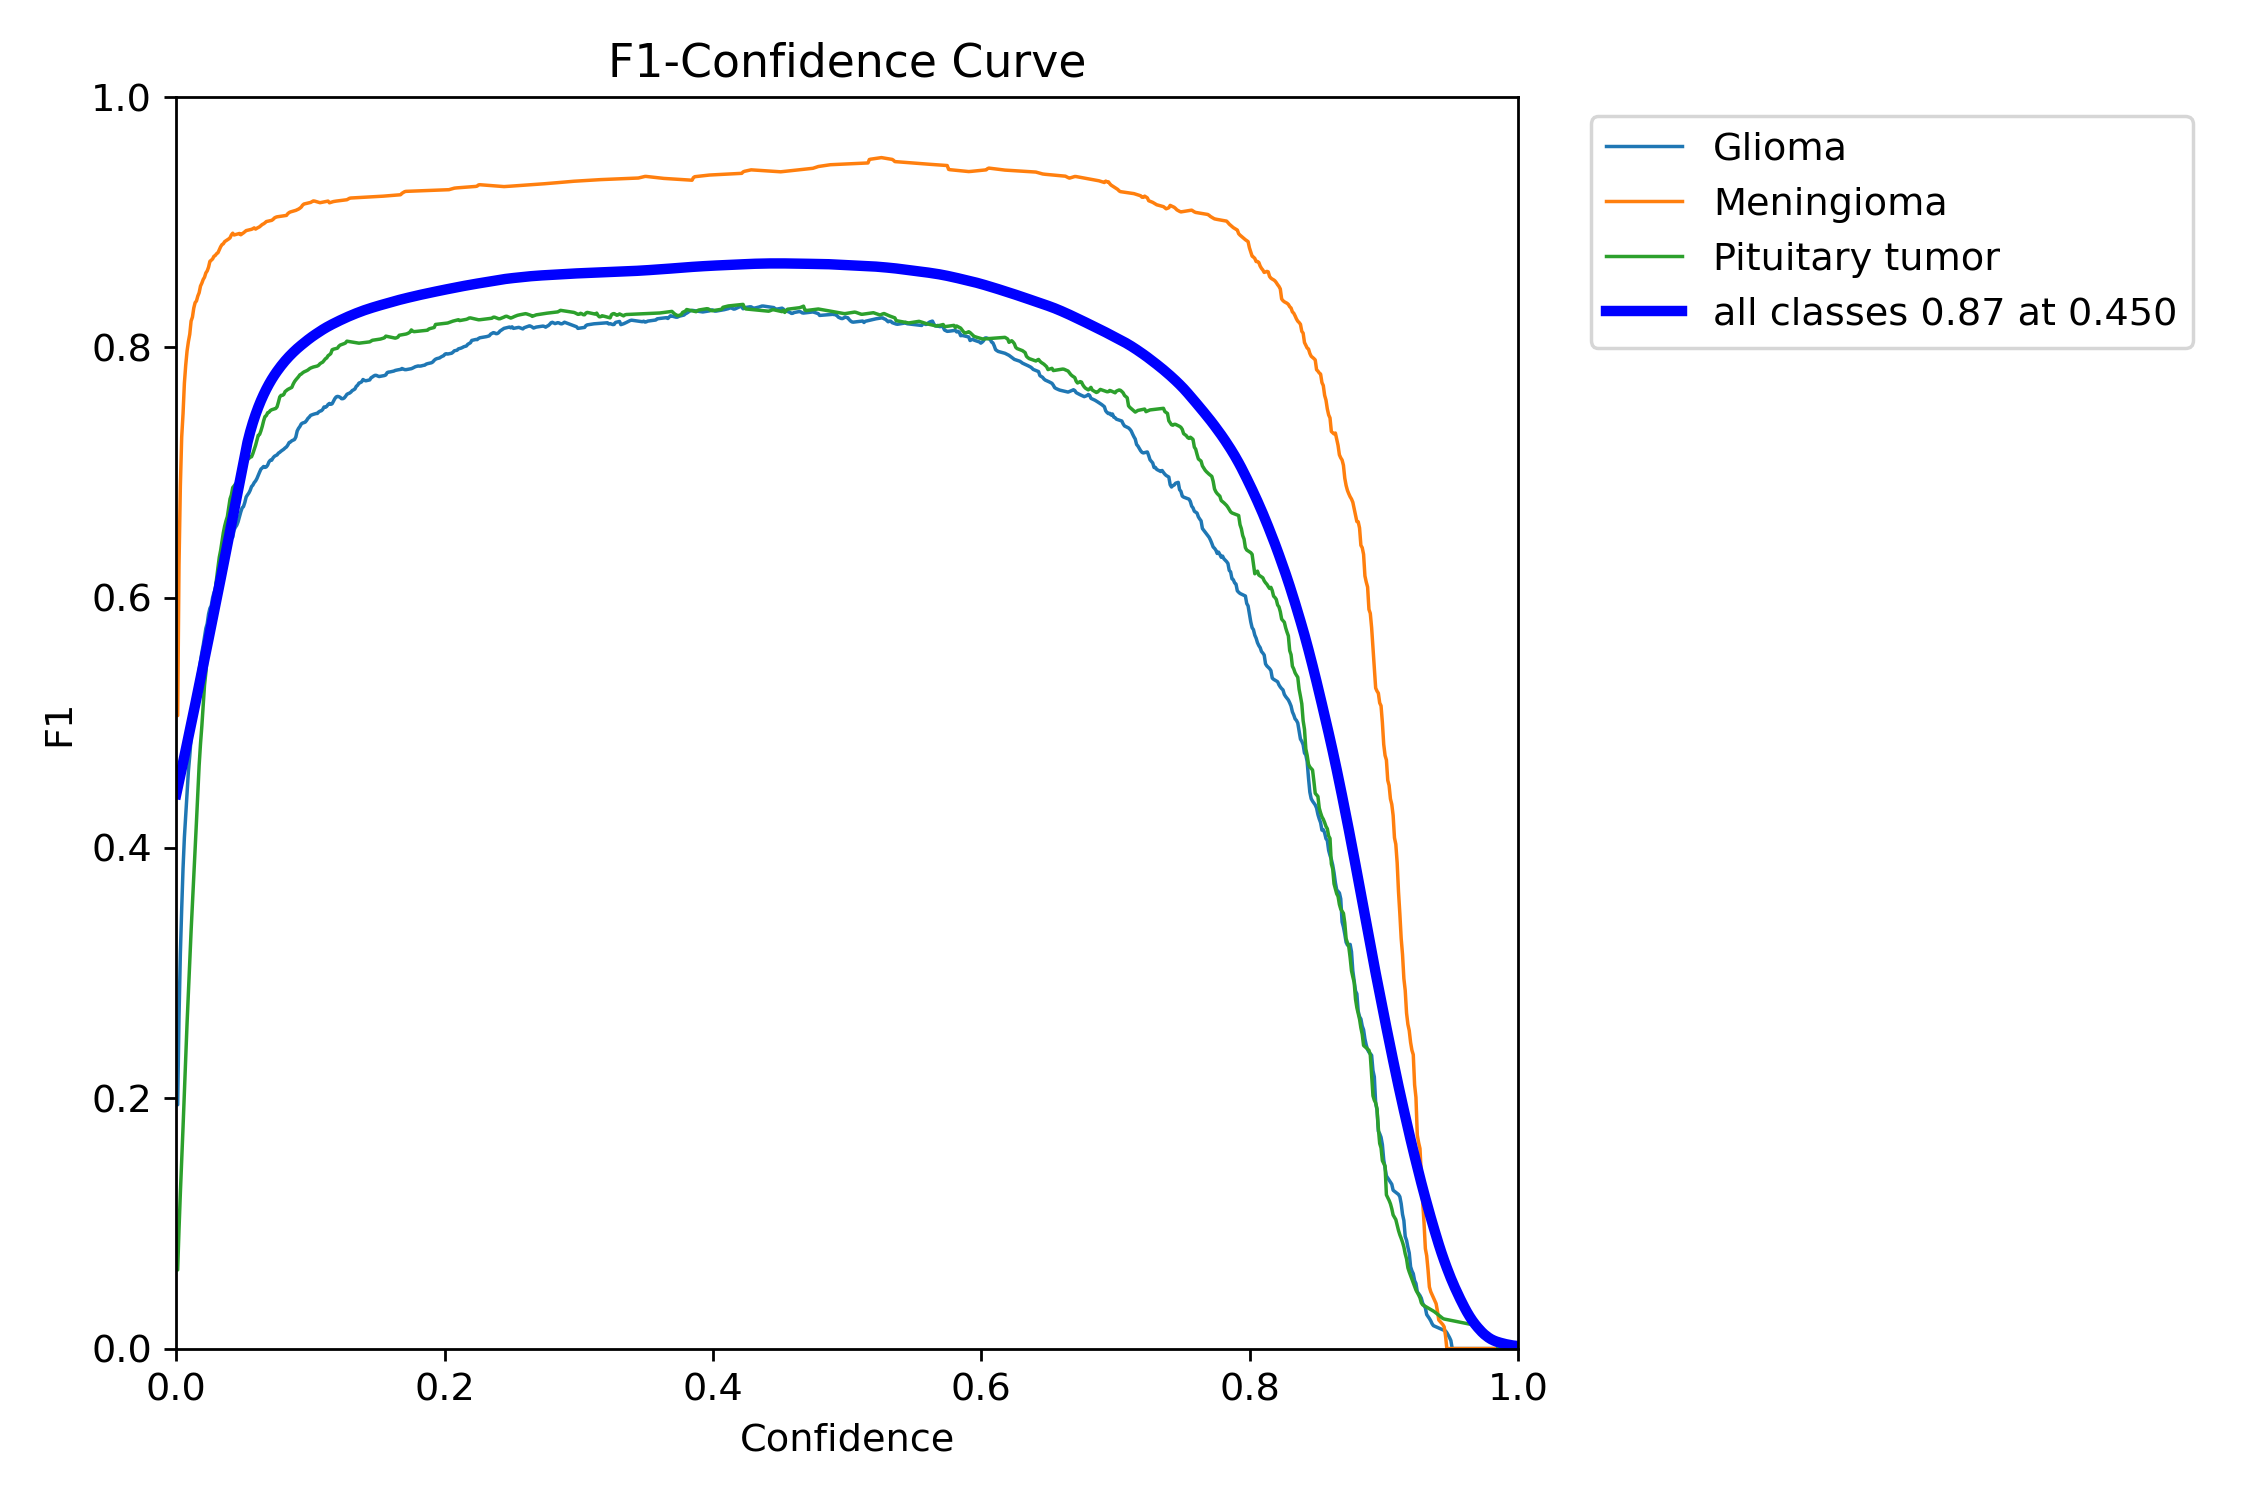

In [ ]:
Image('/content/runs/segment/train/MaskF1_curve.png', height=400, width=600)

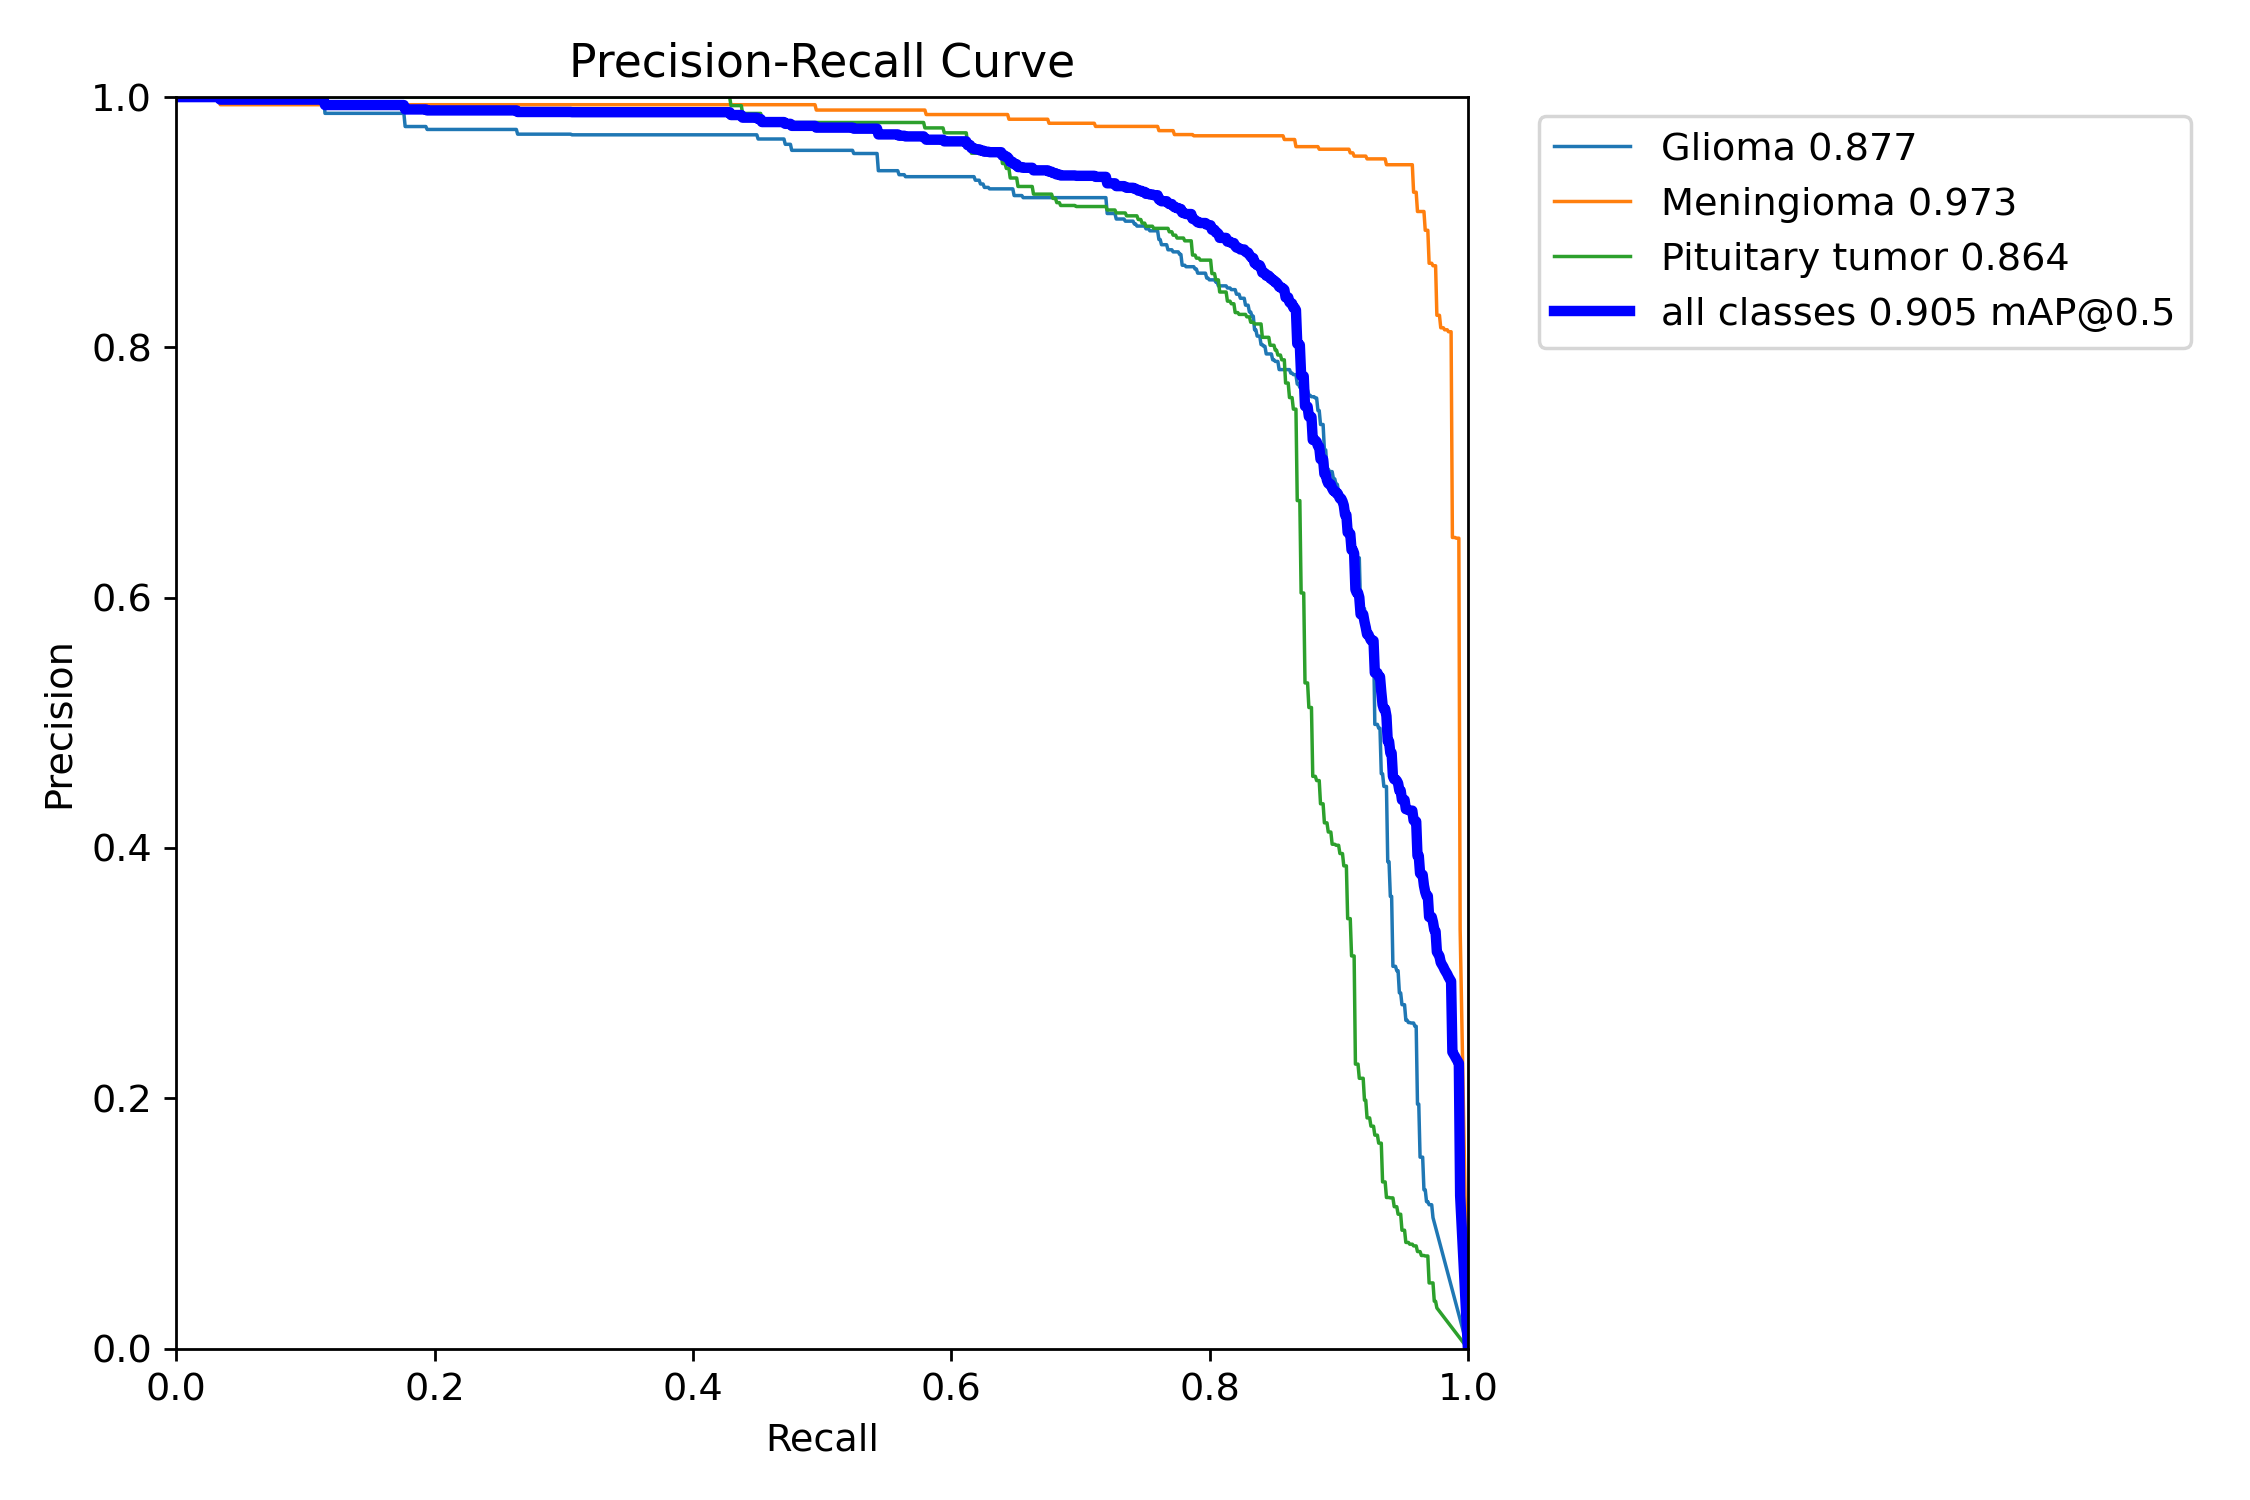

In [ ]:
Image('/content/runs/segment/train/MaskPR_curve.png', height=400, width=600)

In [ ]:
# Run inference on test images
test_results = model.predict(
    source="tumorneuro-1/test/images/",  # path to test images
    conf=0.25,  # confidence threshold (adjust based on your needs)
    save=True,  # save predictions
    save_txt=True,  # save results to .txt file
    save_conf=True,  # save confidence scores in txt file
    show=False,  # show results (for Jupyter/Colab)
    show_labels=True,  # show labels
    show_conf=True,  # show confidence scores
    device=0  # use GPU (0) for inference
)


image 1/742 /content/tumorneuro-1/test/images/1008_jpg.rf.c1a1c897ebaa3d31943b06031bf8edb6.jpg: 640x640 1 Pituitary tumor, 13.7ms
image 2/742 /content/tumorneuro-1/test/images/1010_jpg.rf.fd89f4a99158c0204879c6d59494584e.jpg: 640x640 1 Pituitary tumor, 11.1ms
image 3/742 /content/tumorneuro-1/test/images/1014_jpg.rf.eb35bbf04870c1468328ef4a62475de7.jpg: 640x640 1 Pituitary tumor, 10.6ms
image 4/742 /content/tumorneuro-1/test/images/1014_png_jpg.rf.7e7bb876f21055515806526e410b2dfd.jpg: 640x640 1 Pituitary tumor, 10.9ms
image 5/742 /content/tumorneuro-1/test/images/101_png_jpg.rf.1e018613203bc750d8ff0e6d82b0ff2c.jpg: 640x640 2 Meningiomas, 1 Pituitary tumor, 10.6ms
image 6/742 /content/tumorneuro-1/test/images/1035_jpg.rf.bb1bb01c02817cc3919804af2f131f27.jpg: 640x640 1 Pituitary tumor, 10.5ms
image 7/742 /content/tumorneuro-1/test/images/1039_jpg.rf.bd6dc4f1c19c6f03a9250b3e5ea48105.jpg: 640x640 1 Pituitary tumor, 10.8ms
image 8/742 /content/tumorneuro-1/test/images/1048_png_jpg.rf.b7137

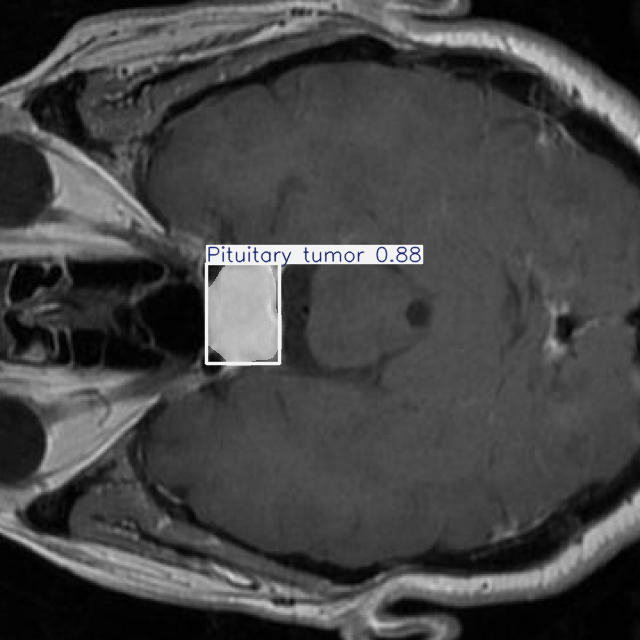


--- Image: 1008_jpg.rf.c1a1c897ebaa3d31943b06031bf8edb6.jpg ---
Detected 1 tumor(s)

Tumor 1:
  Type: Pituitary tumor
  Confidence: 0.88
  BBox: [207, 263, 279, 364]
  Mask points: 66 coordinates


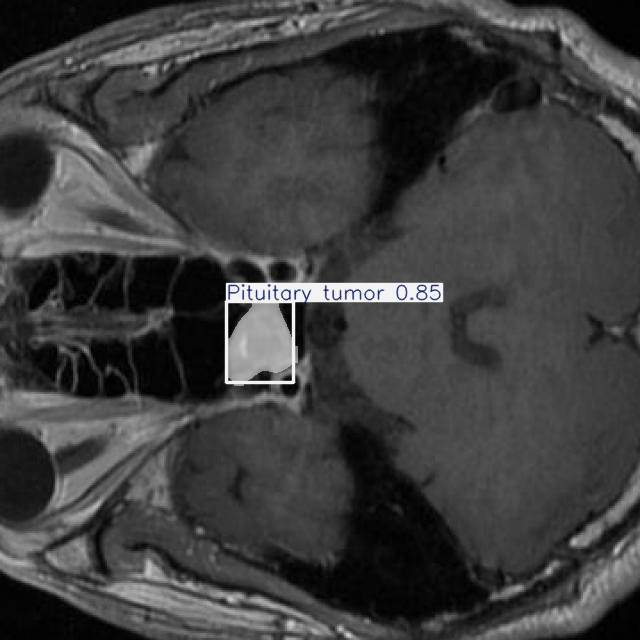


--- Image: 1010_jpg.rf.fd89f4a99158c0204879c6d59494584e.jpg ---
Detected 1 tumor(s)

Tumor 1:
  Type: Pituitary tumor
  Confidence: 0.85
  BBox: [226, 301, 294, 383]
  Mask points: 94 coordinates


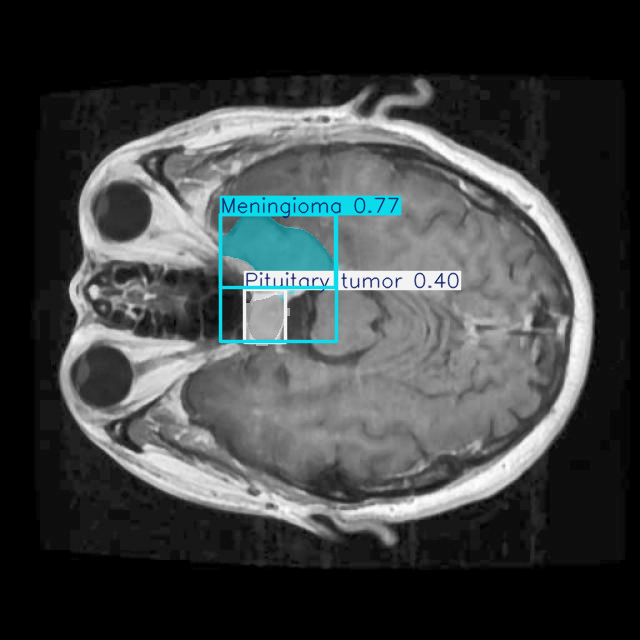


--- Image: 101_png_jpg.rf.1e018613203bc750d8ff0e6d82b0ff2c.jpg ---
Detected 3 tumor(s)

Tumor 1:
  Type: Meningioma
  Confidence: 0.77
  BBox: [221, 215, 335, 288]
  Mask points: 116 coordinates

Tumor 2:
  Type: Meningioma
  Confidence: 0.72
  BBox: [220, 214, 337, 342]
  Mask points: 191 coordinates

Tumor 3:
  Type: Pituitary tumor
  Confidence: 0.40
  BBox: [245, 290, 286, 343]
  Mask points: 56 coordinates


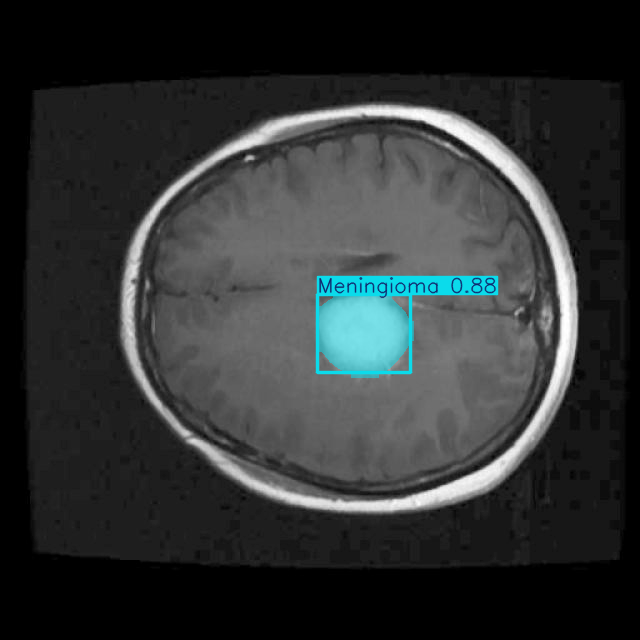


--- Image: 10_png_jpg.rf.d0306550cf039667fcbc62bdc7def635.jpg ---
Detected 1 tumor(s)

Tumor 1:
  Type: Meningioma
  Confidence: 0.88
  BBox: [317, 294, 410, 373]
  Mask points: 71 coordinates


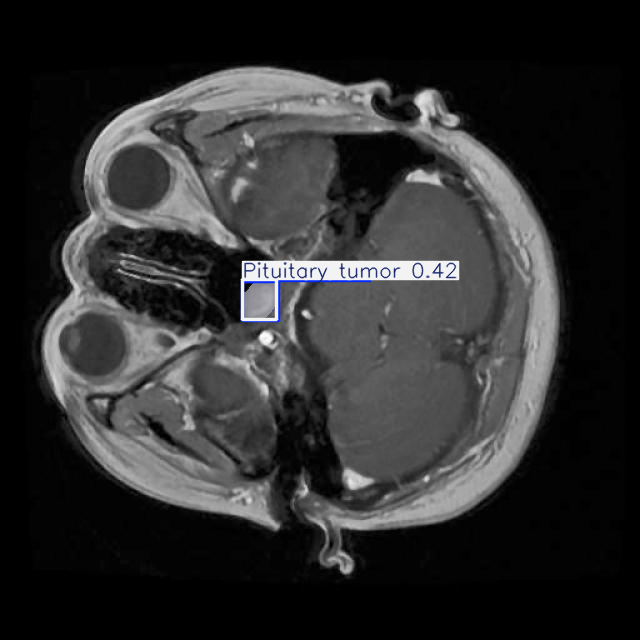


--- Image: 1295_png_jpg.rf.b9b69bf9932d3385bf6c41a96d7d383f.jpg ---
Detected 2 tumor(s)

Tumor 1:
  Type: Pituitary tumor
  Confidence: 0.42
  BBox: [243, 279, 276, 319]
  Mask points: 27 coordinates

Tumor 2:
  Type: Glioma
  Confidence: 0.37
  BBox: [242, 282, 278, 320]
  Mask points: 28 coordinates


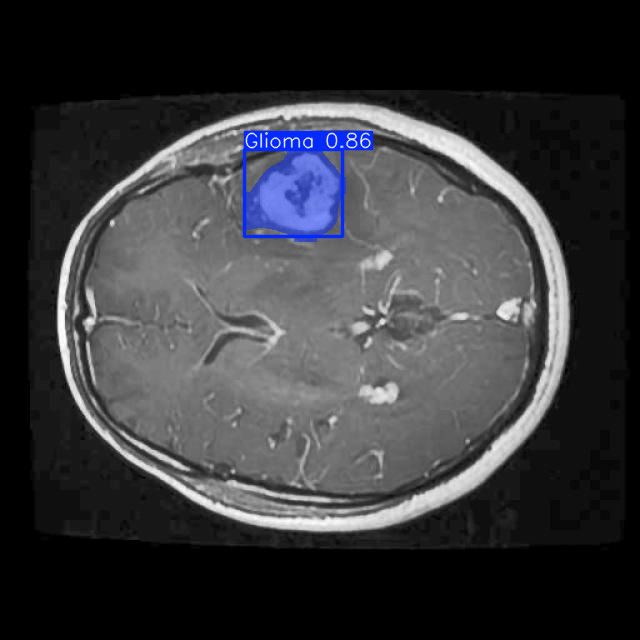


--- Image: 1845_png_jpg.rf.e8f18d2074dd80e6e98835faf17fd5a2.jpg ---
Detected 1 tumor(s)

Tumor 1:
  Type: Glioma
  Confidence: 0.86
  BBox: [244, 149, 342, 237]
  Mask points: 94 coordinates

Samples shown per class:
Glioma: 2 example(s)
Meningioma: 2 example(s)
Pituitary tumor: 2 example(s)


In [ ]:
# Set number of samples to show per class
max_samples_per_class = 2  # Show 2 examples per tumor type

# Initialize counter for each class
samples_shown = {
    'Glioma': 0,
    'Meningioma': 0,
    'Pituitary tumor': 0
}

# Get class names from model (verify order matches your dataset)
class_names = model.names  # Should be ['Glioma', 'Meningioma', 'Pituitary tumor']

for result in test_results:
    # Stop when we've shown enough samples for all classes
    if all(count >= max_samples_per_class for count in samples_shown.values()):
        break

    # Skip images with no detections
    if result.boxes is None or len(result.boxes) == 0:
        continue

    # Track classes in current image
    present_classes = set()

    # Collect class information
    for box in result.boxes:
        cls_idx = int(box.cls)
        present_classes.add(class_names[cls_idx])

    # Check if we need to display this image
    display_image = False
    for cls in present_classes:
        if samples_shown[cls] < max_samples_per_class:
            display_image = True
            break

    if not display_image:
        continue

    # Show the image and results
    result.show()
    print(f"\n--- Image: {os.path.basename(result.path)} ---")
    print(f"Detected {len(result.boxes)} tumor(s)")

    # Print detailed information
    for i, (box, mask, score, cls) in enumerate(zip(result.boxes, result.masks,
                                                  result.boxes.conf, result.boxes.cls)):
        cls_name = class_names[int(cls)]
        print(f"\nTumor {i+1}:")
        print(f"  Type: {cls_name}")
        print(f"  Confidence: {score:.2f}")
        print(f"  BBox: {[round(x) for x in box.xyxy[0].tolist()]}")
        print(f"  Mask points: {len(mask.xy[0])} coordinates")

    # Update counters for shown classes
    for cls in present_classes:
        if samples_shown[cls] < max_samples_per_class:
            samples_shown[cls] += 1

print("\nSamples shown per class:")
for cls, count in samples_shown.items():
    print(f"{cls}: {count} example(s)")

In [ ]:
# Save the model
model.export(format="onnx")  # You can export to other formats like ONNX, TensorRT, etc.

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/segment/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 39, 8400), (1, 32, 160, 160)) (5.7 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 243.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 235.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 232.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 160.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 317.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 17.4s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 

'runs/segment/train/weights/best.onnx'

In [ ]:
# Copy the ONNX Model to Google Drive
import shutil

# Define the source and destination paths
source_path = '/content/runs/segment/train/weights/best.onnx'  # Path to the exported ONNX model
destination_path = '/content/drive/MyDrive/Colab Notebooks/Brain Tumour Detection/best.onnx'  # Path in Google Drive

# Copy the file to Google Drive
shutil.copy(source_path, destination_path)

print(f"Model saved to Google Drive at: {destination_path}")

Model saved to Google Drive at: /content/drive/MyDrive/Colab Notebooks/Brain Tumour Detection/best.onnx


### **Deploy the Model**

In [ ]:
# Google Colab's base image sometimes uses the ASCII (ANSI_X3.4-1968) locale instead of UTF-8. gradio requires UTF-8 encoding for proper installation and operation.
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# Install required packages
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.7 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from ultralytics import YOLO
import cv2
import numpy as np

# Load your trained model
model = YOLO("runs/segment/train/weights/best.pt")  # Update path if needed

def detect_tumor(image):
    # Convert from Gradio's RGB to OpenCV's BGR format
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Run inference
    results = model.predict(image_bgr, conf=0.25)

    # Process results
    output_image = None
    response = []

    for result in results:
        # Get annotated image with boxes and masks
        annotated_image = result.plot()  # Returns BGR image with annotations
        output_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

        # Prepare text response
        if result.boxes:
            for box, cls in zip(result.boxes, result.boxes.cls):
                class_name = model.names[int(cls)]
                confidence = float(box.conf[0])
                response.append({
                    "Type": class_name,
                    "Confidence": f"{confidence:.2%}",
                    "BBox": [round(x) for x in box.xyxy[0].tolist()]
                })
        else:
            response.append({"Result": "No tumors detected"})

    return output_image, response

# Create Gradio interface
interface = gr.Interface(
    fn=detect_tumor,
    inputs=gr.Image(label="Upload Brain Scan"),
    outputs=[
        gr.Image(label="Detection Result"),
        gr.JSON(label="Detection Details")
    ],
    title="Brain Tumor Detection System",
    description="Upload a brain MRI scan to detect tumors (Glioma, Meningioma, Pituitary)",
    # examples=[
    #     ["tumorneuro-1/test/images/Image_1.jpg"],
    #     ["tumorneuro-1/test/images/Image_2.jpg"]
    # ]
)

# Launch the app
interface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9b02b4cb8e3dd80e18.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



0: 640x544 2 Gliomas, 69.5ms
Speed: 5.3ms preprocess, 69.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 Meningioma, 12.2ms
Speed: 3.9ms preprocess, 12.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Pituitary tumor, 14.2ms
Speed: 2.7ms preprocess, 14.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 56.7ms
Speed: 6.4ms preprocess, 56.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 55.1ms
Speed: 4.0ms preprocess, 55.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Meningioma, 89.9ms
Speed: 7.1ms preprocess, 89.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 11.6ms
Speed: 4.0ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Pituitary tumor, 11.4ms
Speed: 3.3ms preprocess, 11.4ms inference, 2.2ms postprocess p